In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

import os
import pickle

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils import find_pauli_indices
from algo.utils import process_hamiltonian_Zs

In [3]:
ham_str = '0.5 - 3 * z0  + 0.5 * z1 * z0 + 0.5 * z2 * z0 + 0.5 * z2 * z1 + 0.5 * z3 * z0 + 0.5 * z3 * z2'
num_q = 4  # Number of qubits
max_stars = 2  # Maximum number of stars to categorize terms (e.g., 0-star, 1-star, 2-star, 3-star)

# Call the function to process the Hamiltonian string
all_lists, all_coeffs = process_hamiltonian_Zs(ham_str, num_q, max_stars)

# Output the results for each star category
for i, (term_positions, term_coeffs) in enumerate(zip(all_lists, all_coeffs)):
    print(f"Terms with {i} star(s):")
    print("Coefficients:", term_coeffs)
    print("Positions:", term_positions)

print('')

List_0, List_1, List_2 = all_lists
List = List_0 + List_1 + List_2

coeff_0, coeff_1, coeff_2 = all_coeffs
coeff = coeff_0 + coeff_1 + coeff_2

H = SparsePauliOp(List, coeff)
Hmat = Operator(H)
Hmat = Hmat.data

# Print with detailed descriptions
print(f"Number of qubits (num_q): {num_q}")
print("List_1 (Pauli terms for XX interactions):")
print(List_1)
print("List_2 (Pauli terms for YY interactions):")
print(List_2)
print(H.size)
print(H)

Terms with 0 star(s):
Coefficients: [0.5]
Positions: ['IIII']
Terms with 1 star(s):
Coefficients: [-3.0]
Positions: ['ZIII']
Terms with 2 star(s):
Coefficients: [0.5, 0.5, 0.5, 0.5, 0.5]
Positions: ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ']

Number of qubits (num_q): 4
List_1 (Pauli terms for XX interactions):
['ZIII']
List_2 (Pauli terms for YY interactions):
['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ']
7
SparsePauliOp(['IIII', 'ZIII', 'ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'],
              coeffs=[ 0.5+0.j, -3. +0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j])


In [4]:
# Compute eigenvalues and eigenvectors
e, v = eigh(Hmat)

# Identify the ground state (minimum eigenvalue)
ground_e = np.min(e)
min_index = np.argmin(e)
v_min = v[:, min_index]  # Ground state eigenvector

# Check degeneracy of the ground state
degeneracy = np.sum(np.isclose(e, ground_e))

# Print warning if ground state is not unique
if degeneracy > 1:
    print(f"Warning: Ground state is not unique. Degeneracy = {degeneracy}. Fidelity is not good metric.")
else:
    print("Ground state is unique.")
    
# Optional: Output for debugging
print(f"Ground state energy: {ground_e}")
print(f"Eigenvalues: {e}")

Ground state is unique.
Ground state energy: -4.0
Eigenvalues: [-4. -3. -3. -3. -3. -2. -2.  0.  2.  3.  3.  3.  3.  4.  4.  6.]


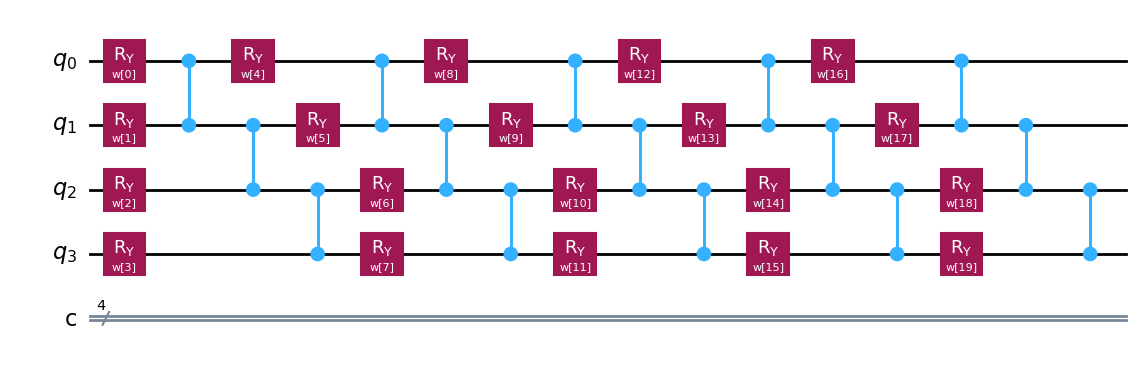

In [5]:
"""circuit construction"""
layer = 5 # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * num_q # Calculate the number of parameters 

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

# Hardware-Efficient Ansatz
def circuit_HEA(weights):
    # ``QuantumCircuit(4, 3) 
    # A QuantumCircuit with 4 qubits and 3 classical bits
    circ = QuantumCircuit(num_q, num_q)  
    
    # for i in range(layer):
    #     # initial state is not |0⟩^⊗n
    #     for j in range(num_q): 
    #         circ.ry(np.pi/4, j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
    #     for j in range(num_q-1):  
    #         circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits


    for i in range(layer):  # Iterate over each layer
        for j in range(num_q): 
            circ.ry(weights[num_q*i+j], j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits
    
    return circ  # Return the constructed quantum circuit

qc = circuit_HEA(weights)
# print(qc)
qc.draw("mpl")


In [6]:
simulator = AerSimulator()

Z_indices = []
ZZ_indices = []

for pauli_str in List_1:
    # print(pauli_str)
    _, _, Z_index = find_pauli_indices(pauli_str)
    Z_indices.append(Z_index)

for pauli_str in List_2:
    # print(pauli_str)
    _, _, ZZ_index = find_pauli_indices(pauli_str)
    ZZ_indices.append(ZZ_index)

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0 
    estimate_2 = 0

    qc = circuit_HEA(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)

    for i in range(SHOTS):
        
        c_i = c[i]

        # List_1 = ['ZIII'] Terms with 1 star
        for j, index in enumerate(Z_indices): 
            if c_i[num_q-1-index[0]] == '0':
                estimate_1 += 1*coeff_1[j]
            else:
                estimate_1 += -1*coeff_1[j]
        
        # List_2 = ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'] Terms with 2 stars
        for j, index in enumerate(ZZ_indices): 
            if c_i[num_q-1-index[0]] == c_i[num_q-1-index[1]]:
                estimate_2 += 1*coeff_2[j]
            else:
                estimate_2 += -1*coeff_2[j]
        

    estimate = estimate_1 + estimate_2
    estimate = estimate/SHOTS + coeff_0[0] # coeff_0[0] for 'IIII'

    return estimate



def expectation_loss(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def fidelity(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2

def std(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    VAR = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(VAR))



In [7]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(std(weights))
print(expectation_loss(weights)/std(weights))

# Check if the observed values from the simulator follow a normal distribution
# Essentially, this is to check whether the estimate_loss function is correct
# It takes a long time
shots = 1000
if False:
    true_value = expectation_loss(weights)

    num_trials = 2000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()



1.5539614513875422
2.7177715524725503
0.5717778044934618


In [8]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1000
print(f"Ground state energy: {ground_e}")




Ground state energy: -4.0


# Performance Metrics as a Function of Scaling Factor k

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Update matplotlib settings with specified fonts and sizes
fontsize = 20
# 全局设置 dpi 和 bbox_inches
matplotlib.rcParams.update({
    'savefig.dpi': 300,  # 设置保存图像时的 DPI
    'savefig.bbox': 'tight',  # 设置保存时去除空白区域
    'font.family': 'serif',
    'axes.labelsize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': 12,
    'axes.titlesize': 20,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'lines.linewidth': 3,
    # 'text.usetex': True,
})
# Define custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


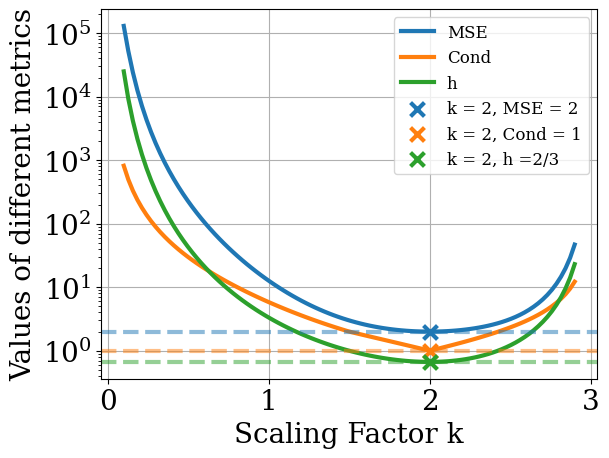

In [10]:

# Given omega values
omegas = [1]

# Interpolation matrix function
def interp_matrix(interp_nodes, omegas):
    r = len(omegas)
    # Build the interpolation matrix
    return np.array([[1/np.sqrt(2)] + [func(omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)] for x in interp_nodes])

# Mean Squared Error (MSE) function
def mse(interp_nodes, omegas):
    # Create interpolation matrix
    A = interp_matrix(interp_nodes, omegas)
    
    # Regularize the matrix (small regularization term to avoid singular matrices)
    regularized_matrix = A.T @ A + 1e-6 * np.eye(A.shape[1])  
    
    # Return the trace of the inverse of the regularized matrix
    return np.trace(np.linalg.inv(regularized_matrix))

# Condition Number function
def cond(interp_nodes, omegas):
    # Compute the condition number of the interpolation matrix
    return np.linalg.cond(interp_matrix(interp_nodes, omegas))

# Average Variance of Derivatives function (h(x))
def h(interp_nodes, omegas, order=1):
    r = len(omegas)

    # Weight diagonal for the variance matrix
    def weight_daigonal(r, order=1):
        diag_elements = [0]  # Start with 0
        for i in range(1, r + 1):
            diag_elements.extend([i**(2 * order), i**(2 * order)])  # Diagonal elements based on order
        return 0.5 * np.diag(diag_elements)

    A = interp_matrix(interp_nodes, omegas)
    regularization = 1e-8 * np.eye(A.shape[1])  # Small regularization term
    VAR = np.linalg.inv(A.T @ A + regularization)
    
    I_d = weight_daigonal(r, order)

    return np.sum(VAR * I_d)

# Initialize lists to store values
mse_values = []
cond_values = []
h_values = []

# Range of k values
# k_values = np.linspace(0.1, 2.9, 100)  # k varies from 0.1 to 2.9 (avoiding k=0)
k_values = np.linspace(0.1, 2.9, 100)  # k varies from 0.1 to 2.9 (avoiding k=0)

r = 2*len(omegas)+1  # Number of interpolation nodes

# Loop to compute MSE, Condition Number, and h for each k
for k in k_values:
    interp_nodes = np.linspace(0, k * np.pi, r, endpoint=False)
    mse_values.append(mse(interp_nodes, omegas))
    cond_values.append(cond(interp_nodes, omegas))
    h_values.append(h(interp_nodes, omegas, order=1))

plt.figure()

# Plotting the results with customized colors
plt.plot(k_values, mse_values, 
         label="MSE", color=colors[0]) #  (Mean Squared Error)
plt.plot(k_values, cond_values, 
         label="Cond", color=colors[1]) # (Condition Number)
plt.plot(k_values, h_values, 
         label="h ", color=colors[2]) # (Average Variance of Derivatives)

# Labels and title
plt.xlabel("Scaling Factor k")
plt.ylabel("Values of different metrics")
plt.yscale('log')  # Set y-axis to logarithmic scale
# plt.title("Performance Metrics as a Function of Scaling Factor k")
plt.grid(True)

# Adding horizontal lines for reference
plt.axhline(y=2, color=colors[0], linestyle='--', alpha=0.5)
plt.axhline(y=1, color=colors[1], linestyle='--', alpha=0.5)
plt.axhline(y=2/3, color=colors[2], linestyle='--', alpha=0.5)

# Highlight the point at k = 2
k_target = 2
interp_nodes_target = np.linspace(0, k_target * np.pi, 2 * len(omegas) + 1, endpoint=False)

mse_target = mse(interp_nodes_target, omegas)
cond_target = cond(interp_nodes_target, omegas)
h_target = h(interp_nodes_target, omegas, order=1)

# Mark the point on the plot (k = 2, MSE value)
plt.scatter(k_target, mse_target, 
            color=colors[0], marker='x', s=100, zorder=5, 
            label=f'k = {k_target}, MSE = {mse_target:.0f}')
plt.scatter(k_target, cond_target, 
            color=colors[1], marker='x', s=100, zorder=5, 
            label=f'k = {k_target}, Cond = {cond_target:.0f}')
plt.scatter(k_target, h_target, 
            color=colors[2], marker='x', s=100, zorder=5, 
            label=f'k = {k_target}, h =2/3')

# Display legend
plt.legend()

plt.savefig('metrics_with_diff_iterp_nodes.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# nosiy data

In [12]:
from algo.oicd import oicd

# Initialization
omegas = [1]
num_iter = 300  # Number of iterations for optimization

# Define different sets of `interp_nodes` for comparison
r=2 * len(omegas) + 1
k_set = [0.5, 1, 1.5, 2]
interp_configs = [np.linspace(0, k * np.pi, r, endpoint=False) for k in k_set]
MSE_values = [mse(nodes, omegas) for nodes in interp_configs]


In [13]:

# Initialize dictionary for weight configurations
weights_dict = {}

# Store the best expected record values for each `interp_nodes`
best_expected_values = []
best_fid_record_value = []
every_expected = []
every_fid = []

# Loop over the different `interp_nodes` configurations
for interp_nodes in interp_configs:
    # Compute the inverse of the interpolation matrix
    inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
    
    # Update the weights_dict with the current configuration
    for i in range(num_p):
        weights_dict[f'weights_{i}'] = {
            'omegas': omegas,
            'scale_factor': 1.0,
            'interp_nodes': interp_nodes,
            'inverse_interp_matrix': inverse_interp_matrix,
        }

    # Run OICD optimization
    final_weights_oicd, best_expected_record_value_oicd, best_fid_record_value_oicd, func_oicd, every_expected_oicd, every_fid_oicd  = oicd(
        estimate_loss,
        expectation_loss,
        fidelity,
        n_shot, weights_dict, initial_weights, num_iter,
        cyclic_mode=False,
        use_pratical_interp_flag=True,
        use_local_solvers_flag=False,
        use_global_solvers_flag=False,
        use_exact_update_frequencey_1_flag=True,
        exact_mode=False,  # No noisy loss for testing
        plot_flag=False,  # Disable automatic plot generation
        plot_argmin_flag=False
    )
    
    # Store the best expected record value for the current configuration
    best_expected_values.append(best_expected_record_value_oicd / ground_e)
    best_fid_record_value.append(best_fid_record_value_oicd)
    every_expected.append(every_expected_oicd / ground_e)
    every_fid.append(every_fid_oicd)


----------------------------------------------------------------------------------------------------


Bar desc:   0%|          | 0/300 [00:00<?, ?it/s]

[OICD] Iter: 299, 11(20), Best loss: -3.0513, Cur. loss: 0.1457, Best Fid.: 0.6376, Cur. Fid.: 0.0059: 100%|██████████| 300/300 [00:18<00:00, 16.43it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 1(20), Best loss: -3.8867, Cur. loss: 2.3578, Best Fid.: 0.9525, Cur. Fid.: 0.0020: 100%|██████████| 300/300 [00:18<00:00, 16.06it/s]  


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Best loss: -3.9601, Cur. loss: 1.9066, Best Fid.: 0.9819, Cur. Fid.: 0.0000: 100%|██████████| 300/300 [00:19<00:00, 15.67it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 17(20), Best loss: -3.9972, Cur. loss: -3.9950, Best Fid.: 0.9986, Cur. Fid.: 0.9970: 100%|██████████| 300/300 [00:20<00:00, 14.60it/s]


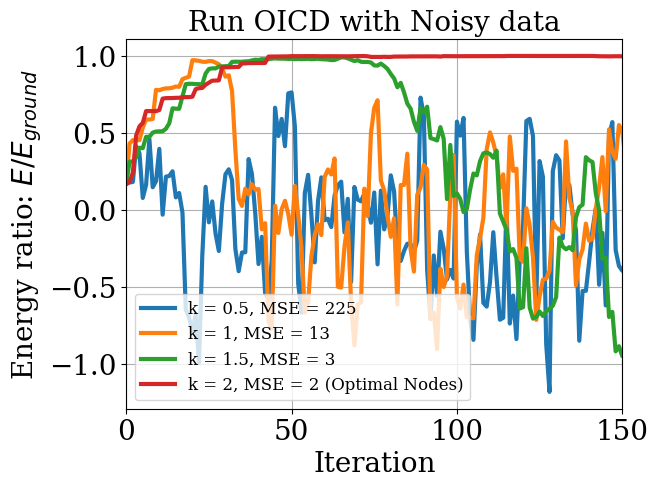

In [14]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(every_expected):
    label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f}'
    if idx == len(every_expected) - 1:
        label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f} (Optimal Nodes)'
    plt.plot(values, label=label)

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Energy ratio: $E / E_{ground}$")
plt.xlim(0, 150)
plt.title("Run OICD with Noisy data")
plt.legend()
plt.grid(True)
plt.savefig('maxcut_oicd_with_diff_iterp_nodes_fun_evals_nosiydata.png')
plt.show()

# true data

In [15]:
from algo.oicd import oicd

# Initialization
omegas = [1]
num_iter = 250  # Number of iterations for optimization

# Define different sets of `interp_nodes` for comparison
r=2 * len(omegas) + 1
k_set = [0.5, 1, 1.5, 2]
interp_configs = [np.linspace(0, k * np.pi, r, endpoint=False) for k in k_set]
MSE_values = [mse(nodes, omegas) for nodes in interp_configs]


In [16]:

# Initialize dictionary for weight configurations
weights_dict = {}

# Store the best expected record values for each `interp_nodes`
best_expected_values2 = []
best_fid_record_value2 = []
every_expected2 = []
every_fid2 = []

# Loop over the different `interp_nodes` configurations
for interp_nodes in interp_configs:
    # Compute the inverse of the interpolation matrix
    inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
    
    # Update the weights_dict with the current configuration
    for i in range(num_p):
        weights_dict[f'weights_{i}'] = {
            'omegas': omegas,
            'scale_factor': 1.0,
            'interp_nodes': interp_nodes,
            'inverse_interp_matrix': inverse_interp_matrix,
        }

    # Run OICD optimization
    final_weights_oicd, best_expected_record_value_oicd, best_fid_record_value_oicd, func_oicd, every_expected_oicd, every_fid_oicd  = oicd(
        estimate_loss,
        expectation_loss,
        fidelity,
        n_shot, weights_dict, initial_weights, num_iter,
        cyclic_mode=False,
        use_pratical_interp_flag=True,
        use_local_solvers_flag=False,
        use_global_solvers_flag=False,
        use_exact_update_frequencey_1_flag=True,
        exact_mode=True,  # No noisy loss for testing
        plot_flag=False,  # Disable automatic plot generation
        plot_argmin_flag=False
    )
    
    # Store the best expected record value for the current configuration
    best_expected_values2.append(best_expected_record_value_oicd / ground_e)
    best_fid_record_value2.append(best_fid_record_value_oicd)
    every_expected2.append(every_expected_oicd / ground_e)
    every_fid2.append(every_fid_oicd)


----------------------------------------------------------------------------------------------------


[OICD] Iter: 249, 4(20), Best loss: -3.9958, Cur. loss: -3.9958, Best Fid.: 0.9982, Cur. Fid.: 0.9981: 100%|██████████| 250/250 [00:11<00:00, 21.18it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 249, 14(20), Best loss: -3.9936, Cur. loss: -3.9936, Best Fid.: 0.9972, Cur. Fid.: 0.9972: 100%|██████████| 250/250 [00:11<00:00, 21.65it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 221, 0(20), Best loss: -3.9952, Cur. loss: -3.9952, Best Fid.: 0.9990, Cur. Fid.: 0.9990:  88%|████████▊ | 221/250 [00:10<00:01, 20.92it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 74, 8(20), Best loss: -3.9960, Cur. loss: -3.9960, Best Fid.: 0.9993, Cur. Fid.: 0.9993:  30%|██▉       | 74/250 [00:03<00:07, 22.44it/s] 


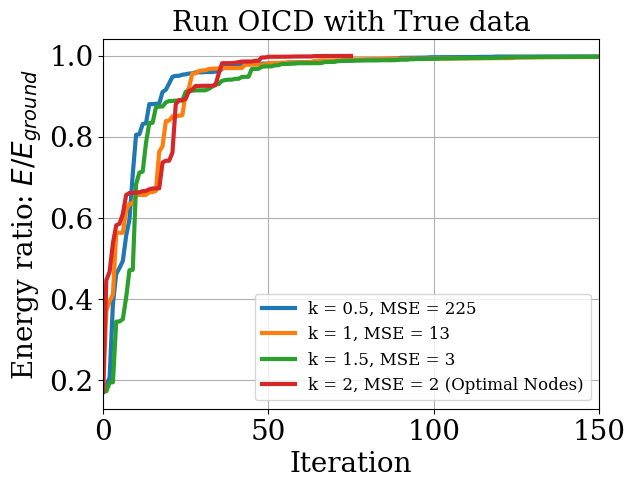

In [17]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(every_expected2):
    label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f}'
    if idx == len(every_expected) - 1:
        label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f} (Optimal Nodes)'
    plt.plot(values, label=label)

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Energy ratio: $E / E_{ground}$")
plt.xlim(0, 150)
plt.title("Run OICD with True data")
plt.legend()
plt.grid(True)
plt.savefig('maxcut_oicd_with_diff_iterp_nodes_fun_evals_truedata.png')
plt.show()